# Dog Classification using PyTorch, Azure, and Visual Studio Code

Have you ever seen a dog and not been able to tell the breed? Some dogs look so similar, that it can be nearly impossible to tell. For instance these are a few breeds that are difficult to tell apart:

#### Alaskan Malamutes vs Siberian Huskies
![Image of Alaskan Malamute vs Siberian Husky](http://cdn.akc.org/content/article-body-image/malamutehusky.jpg)

#### Whippet vs Italian Greyhound 
![Image of Whippet vs Italian Greyhound](http://cdn.akc.org/content/article-body-image/whippetitalian.jpg)

There are sites like http://what-dog.net, which use Microsoft Cognitive Services to be able to make this easier. 

In this tutorial, you will learn how to train your own image classification model using transfer learning. The Azure Machine Learning python SDK's [PyTorch estimator](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-train-pytorch) enables you to easily submit PyTorch training jobs for both single-node and distributed runs on Azure compute. The model is trained to classify dog breeds using a pretrained ResNet18 model that has been trained on the [Stanford Dog dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. In the interest of time, we will use a subset of this dataset which includes 10 dog breeds.

## What is Azure Machine Learning service?
Azure Machine Learning service (Preview) is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.
![](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/overview-what-is-azure-ml/aml.png)

## Prerequisites
1. Sign up for an [Azure account](https://azure.microsoft.com/en-ca/free/search). In this workshop, you can choose to use your own account or use the AAD credentials provided to you. 

2. Install the Azure Machine Learning SDK by running the follwing cell. Once finished, use menu Kernel -> Restart to restart the kernel.


In [5]:
!pip install --upgrade azureml-sdk

# Check core SDK version number
import azureml.core
print("SDK version:", azureml.core.VERSION)

Requirement already up-to-date: azureml-sdk in c:\users\ronglu\appdata\local\continuum\anaconda3\lib\site-packages (1.0.23)


You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


SDK version: 1.0.23


# Train image classification models
Training machine learning models, particularly deep neural networks, is often a time- and compute-intensive task. Once you've finished writing your training script and running on a small subset of data on your local machine, you will likely want to scale up your workload. The Azure Machine Learning service enables users to easily train their models in the Azure ecosystem, and it also provides built-in support for popular machine learning frameworks, such as PyTorch and TensorFlow, to simplify the workflow.

### Steps to train models:

1. Connect to an Azure Machine Learning service Workspace 
2. Create a remote compute
3. Upload your training data (Optional)
4. Prepare your training script
5. Submit a training job to AML

## 1. Connect to the Azure Machine Learning service workspace
We have prepared a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) to use in this tutorial. Run the following code to connect to this workspace, or to create a new workspace for yourself if you change subscription_id to be your own subscription in the code.

**You will be asked to login during this step. Please use the AAD credentials provided to you.**

In [2]:
from azureml.core.workspace import Workspace

subscription_id = "b856ff87-00d1-4205-af56-3af5435ae401"
resource_group = "PyCon2019"
workspace_name = "PyCon2019" 
workspace_region = "eastus"

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.write_config()

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Found the config file in: D:\Conferences\2019 PyCon\PyCon-2019\.azureml\config.json
Workspace name: PyCon2019
Azure region: eastus
Subscription id: b856ff87-00d1-4205-af56-3af5435ae401
Resource group: PyCon2019


## 2. Create a remote compute target
For this tutorial, we have prepared an AML Compute cluster with NC6s_v2, P100 GPU machines to use as the [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) to execute your training script on. 

The following code creates a cluster for you if it does not already exist in your workspace. Otherwise, it will skip the cluster creation process.

**Creation of the cluster takes approximately 5 minutes.** 

In [12]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "PyconCluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6s_v2', 
                                                           min_nodes=1,
                                                           max_nodes=2,
                                                           idle_seconds_before_scaledown='300')

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

    # Use the 'status' property to get a detailed status for the current cluster. 
    print(compute_target.status.serialize())

Found existing compute target.


## 3. Upload training data (Optional)

**Note: For this workshop, we have uploaded the training data in advance, so this step is optional. But feel free to run through the content if you're interested.**

In this tutorial, we will use 10 classes of images for training. Each class represents one dog breed and consists ~150 images: 100 are traning images for dog breeds, and ~50 are validation images for each class. You can view the data used [here](https://github.com/ronglums/PyCon-2019/tree/master/breeds-10). 



First, download the dataset (located [here](https://github.com/ronglums/PyCon-2019/blob/master/breeds-10.zip) as a zip file) locally to your current directory and extract the files. This will create a folder called breeds-10 with two subfolders train and val that contain the training and validation images, respectively.

In [8]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = 'https://github.com/ronglums/PyCon-2019/raw/master/breeds-10.zip'
data_file = './breeds-10.zip'
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, 'r') as zip:
    print('extracting files...')
    zip.extractall()
    print('done')
    
# delete zip file
os.remove(data_file)

extracting files...
done


To make the data accessible for remote training, you will need to upload the data from your local machine to the cloud. AML provides a convenient way to do so via a Datastore. The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets.

Each workspace is associated with a default datastore. In this tutorial, we will upload the training data to this default datastore. The following code will upload the training data to the path ./breeds-10 on the default datastore.

**Note: If your data is already stored in Azure, or you download the data as part of your training script, you will not need to do this step.**

In [4]:
ds = ws.get_default_datastore()
ds.upload(src_dir='./breeds-10', target_path='breeds-10')
print(ds.datastore_type, ds.account_name, ds.container_name)

Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_10621.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_10976.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_11140.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_11238.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_11258.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_1152.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_11948.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_12101.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_12334.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_1298.jpg
Target alrea

Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_7700.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_7738.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_8420.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_8491.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_8558.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_8585.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_8611.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_8636.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_8637.jpg
Target already exists. Skipping upload for breeds-10\train\n02085620-Chihuahua\n02085620_9351.jpg
Target already exist

Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_5678.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_570.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_5872.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_5942.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_5975.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_6223.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_636.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_651.jpg
Target already exists. Skipping upload for breeds-10\train\n02091032-Italian_greyhound\n02091032_652.jpg
Target already exists. Skipping upload for breeds-

Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_16062.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_16086.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_16201.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_16541.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_16794.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_16904.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_17054.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_17108.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_17567.jpg
Target already exists. Skipping upload for breeds-10\train\n02091134-whippet\n02091134_17608.jpg
Target already exists. Skippin

Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_281.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_286.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_3004.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_304.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_3073.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_308.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_3202.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_3262.jpg
Target already exists. Skipping upload for breeds-10\train\n02099601-golden_retriever\n02099601_3327.jpg
Target already exists. Skipping upload for breeds-10\train\

Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_11668.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_11955.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_12087.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_12412.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_12455.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_12556.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_12801.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_13071.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_13090.jpg
Target already exists. Skipping uploa

Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7527.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7560.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7607.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7612.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7708.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7717.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7763.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_7896.jpg
Target already exists. Skipping upload for breeds-10\train\n02105855-Shetland_sheepdog\n02105855_8378.jpg
Target already exists. Skipping upload for bre

Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_2659.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_27186.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_2740.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_2810.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_320.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_3260.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_3781.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_3815.jpg
Target already exists. Skipping upload for breeds-10\train\n02106662-German_shepherd\n02106662_3953.jpg
Target already exists. Skipping upload for breeds-10\train\n0210

Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_268.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2718.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2740.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2741.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2791.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2796.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2815.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2917.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_2953.jpg
Target already exists. Skipping upload for breeds-10\train\n02108089-boxer\n02108089_3028.jpg
Target already exists. Skipping upload for breeds-10\train\n0

Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_13794.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_13804.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_13812.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_14676.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_15579.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_16100.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_16215.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_1624.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint_Bernard\n02109525_16284.jpg
Target already exists. Skipping upload for breeds-10\train\n02109525-Saint

Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_11658.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_11709.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_11756.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_11814.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_11822.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_12139.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_12269.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_12294.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_12326.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_12330.jpg
Target already exist

Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_938.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_97.jpg
Target already exists. Skipping upload for breeds-10\train\n02110063-malamute\n02110063_9861.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_10047.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_10171.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_10273.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_10360.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_1066.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_10875.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n0211

Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_6780.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_6850.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_7044.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_7117.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_712.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_7210.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_7246.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_7379.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siberian_husky\n02110185_7762.jpg
Target already exists. Skipping upload for breeds-10\train\n02110185-Siber

Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_11062.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_11119.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_1121.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_11549.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_1170.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_12144.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_1228.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_1248.jpg
Target already exists. Skipping upload for breeds-10\val\n02091032-Italian_greyhound\n02091032_1358.jpg
Target already exists. Skipping upload for breeds-10\val\n02

Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_11875.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_12017.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_12023.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_12138.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_12272.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_12375.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_12581.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_12759.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_13109.jpg
Target already exists. Skipping upload for breeds-10\val\n02091134-whippet\n02091134_13334.jpg
Target already exists. Skipping upload for breeds-

Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_2358.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_238.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_2408.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_2440.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_2980.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_2994.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_3007.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_3097.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_retriever\n02099601_3111.jpg
Target already exists. Skipping upload for breeds-10\val\n02099601-golden_

Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_190.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_19204.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_19616.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_19926.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_2094.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_2433.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_3168.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_3399.jpg
Target already exists. Skipping upload for breeds-10\val\n02105855-Shetland_sheepdog\n02105855_3434.jpg
Target already exists. Skipping upload for breeds-10\val\n0210

Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_11807.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_11875.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_122.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_12738.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_12739.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_13526.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_1410.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_14112.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_149.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02108089_1511.jpg
Target already exists. Skipping upload for breeds-10\val\n02108089-boxer\n02

Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_1902.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_1972.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_2737.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_345.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_370.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_4308.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_5007.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_5385.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_5966.jpg
Target already exists. Skipping upload for breeds-10\val\n02109525-Saint_Bernard\n02109525_6593.jpg
Ta

Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_3853.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_3899.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_4739.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_566.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_5727.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_5828.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_5829.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_6083.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_6276.jpg
Target already exists. Skipping upload for breeds-10\val\n02110063-malamute\n02110063_642.jpg
Target already exists. Skipping upload for breeds-10

Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_6473.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_6564.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_6746.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_698.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_699.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_725.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_7329.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_7413.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_7564.jpg
Target already exists. Skipping upload for breeds-10\val\n02110185-Siberian_husky\n02110185_75

AzureBlob pycon201storageilijgslv azureml-blobstore-c7484f61-790f-4aa4-9419-45985442613f


Now let's get a reference to the path on the datastore with the training data. We can do so using the `path` method. In the next section, we can then pass this reference to our training script's `--data_dir` argument. 

In [5]:
path_on_datastore = 'breeds-10'
ds_data = ds.path(path_on_datastore)
print(ds_data)

$AZUREML_DATAREFERENCE_9e4cdfbf4da149aa9fe5a5ff74343edd


**If you already have a datstore uploaded you can access it through the following code:**

`from azureml.core.datastore import Datastore
ds= Datastore.get(ws,"breeds")`

**Download Data (Optional)**

If you are interested in downloading the data locally, you can run `ds.download("./", 'breeds-10')`. This might take several minutes.

## 4. Prepare your training script

### Create a project directory
Create a directory that will contain all the necessary code from your local machine, in this case, Azure Notebooks, that you will need access to on the remote resource. This includes the training script and any additional files your training script depends on.

In [7]:
import os

project_folder = './pytorch-dog-breeds-10'
os.makedirs(project_folder, exist_ok=True)

### Prepare training script
In this tutorial, the training script is already provided for you at `pytorch_train-10.py`. In practice, you should be able to take any custom training script as is and run it with AML without having to modify your code.

However, if you would like to use AML's [tracking and metrics](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#metrics) capabilities, you will have to add a small amount of AML code inside your training script. 

In `pytorch_train_10.py`, we will log some metrics to our AML run. To do so, we will access the AML run object within the script:
```Python
from azureml.core.run import Run
run = Run.get_context()
```
Further within `pytorch_train_10.py`, we log the learning rate and momentum parameters, and the best validation accuracy the model achieves:
```Python
run.log('lr', np.float(learning_rate))
run.log('momentum', np.float(momentum))

run.log('best_val_acc', np.float(best_acc))
```

Once your script is ready, copy the training script `pytorch_train_10.py` into your project directory.

In [8]:
import shutil
shutil.copy('pytorch_train_10.py', project_folder)

'./pytorch-dog-breeds-10\\pytorch_train_10.py'

## 5. Submit a training job to AML
Now that you have your data and training script prepared, you are ready to train on your remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time.     

### Create an experiment
An experiment is a grouping of many runs from a specified script. Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) to track all the runs in your workspace for this transfer learning PyTorch tutorial. 

**Please enter your own unique name so that you can track your specific runs.**

In [10]:
from azureml.core import Experiment

#experiment_name = <<ENTER UNIQUE NAME HERE>> ## An example would be "pytorch-dogs-hs"
experiment_name = 'myspecialexp'
experiment = Experiment(ws, name=experiment_name)

print(experiment)

<azureml.core.workspace.Workspace object at 0x000002A43A41BDD8> myspecialexp


### Create a PyTorch estimator
The AML SDK's PyTorch estimator enables you to easily submit PyTorch training jobs for both single-node and distributed runs. For more information on the PyTorch estimator, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-train-pytorch). The following code will define a single-node PyTorch job.

In [13]:
from azureml.train.dnn import PyTorch

script_params = {
    '--data_dir': ds_data.as_mount(),
    '--num_epochs': 10,
    '--output_dir': './outputs'
}

estimator = PyTorch(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=compute_target, 
                    entry_script='pytorch_train_10.py',
                    use_gpu=True)


The `script_params` parameter is a dictionary containing the command-line arguments to your training script `entry_script`. Please note the following:
- We passed our training data reference `ds_data` to our script's `--data_dir` argument. This will 1) mount our datastore on the remote compute and 2) provide the path to the training data `breeds` on our datastore.
- We specified the output directory as `./outputs`. The `outputs` directory is specially treated by AML in that all the content in this directory gets uploaded to your workspace as part of your run history. The files written to this directory are therefore accessible even once your remote run is over. In this tutorial, we will save our trained model to this output directory.

To leverage the Azure VM's GPU for training, we set `use_gpu=True`.

### Submit the training job
Now let's submit the experiment run to the AML service. Note that this call is asynchronous.

In [14]:
run = experiment.submit(estimator)
print(run.get_details())

{'runId': 'myspecialexp_1555807759_d5894295', 'target': 'PyconCluster', 'status': 'Running', 'startTimeUtc': '2019-04-21T00:49:30.215317Z', 'warnings': [{'source': 'Run', 'message': 'Ignoring the provided userId for the createdBy property.'}], 'properties': {'azureml.runsource': 'experiment', 'ContentSnapshotId': 'b4a079df-5404-4394-b9f9-0bc35e3250c3'}, 'runDefinition': {'script': 'pytorch_train_10.py', 'arguments': ['--data_dir', '$AZUREML_DATAREFERENCE_e7222540efcd4ba99e6d11699e3a8ad6', '--num_epochs', '10', '--output_dir', './outputs'], 'sourceDirectoryDataStore': None, 'framework': 'Python', 'communicator': 'None', 'target': 'PyconCluster', 'dataReferences': {'e7222540efcd4ba99e6d11699e3a8ad6': {'dataStoreName': 'workspaceblobstore', 'mode': 'Mount', 'pathOnDataStore': 'breeds-10', 'pathOnCompute': None, 'overwrite': False}}, 'jobName': None, 'autoPrepareEnvironment': True, 'maxRunDurationSeconds': None, 'nodeCount': 1, 'environment': {'name': 'Experiment myspecialexp Environment',

### Monitor your run
Once the run is submitted, you can monitor the progress of the run with a Jupyter widget. Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [18]:
!pip install azureml-widgets

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Known nbextensions:
  config dir: C:\Users\ronglu\AppData\Local\Continuum\anaconda3\etc\jupyter\nbconfig
    notebook section
      azureml_widgets/extension enabled 
      plotlywidget/extension enabled 
      jupyter-js-widgets/extension enabled 


      - Validating: ok
      - Validating: ok
      - Validating: ok


In [20]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## While you're waiting for your model to be trained, feel free to play with an existing web service  (Optional)
**The run will take a few minutes - check the widget above for its status. While you're waiting, you could try to test images against a pre-trained model. Please navigate to [webservice-test.ipynb](./webservice-test.ipynb).**

## Deploy the model as a web service

Once the wiget shows the run is compete, we are ready to deploy this model as a web service for predictions.

In this tutorial, we will:

1. Register the model with AML
2. Deploy the model as a web service

### 1. Register the model with AML
Model registration allows you to store and version your models in the Azure cloud, in your workspace. The model registry makes it easy to organize and keep track of your trained models.

**Please use a unique name for the model**. You will need to edit the init() function in the pytorch_score.py file to match the unique name used. Change the line `model_path = Model.get_model_path('dogs')` to use the unique name.

In [21]:
model = run.register_model(model_name= 'myspecialmodel', model_path = 'outputs/model.pt')
print(model.name, model.id, model.version, sep = '\t')

myspecialmodel	myspecialmodel:1	1


In [ ]:
## if you need to reference the run object specifically uncomment this section

# from azureml.core import Run
# run = Run(experiment, run_id="") 

### 2. Deploy model as web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances (ACI), Azure Kubernetes Service (AKS), IoT edge device, or field programmable gate arrays (FPGAs). ACI is generally cheaper than AKS and can be set up in 4-6 lines of code. ACI is the perfect option for testing deployments. Later, when you're ready to use your models and web services for high-scale, production usage, you can deploy them to AKS.

In this tutorial, we will deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/) (ACI). 

For more information on deploying models using Azure ML, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).

### Create scoring script

First, we will create a scoring script that will be invoked by the web service call. Note that the scoring script must have two required functions:
* `init()`: In this function, you typically load the model into a `global` object. This function is executed only once when the Docker container is started. 
* `run(input_data)`: In this function, the model is used to predict a value based on the input data. The input and output typically use JSON as serialization and deserialization format, but you are not limited to that.

Here's the scoring file that our web service will use this file to predict the breed of the dog in the image. 

**IMPORTANT: update the model name to be yours.**

When writing your own scoring script, don't forget to test it locally first before you go and deploy the web service.

In [30]:
%%writefile pytorch_score.py
import torch
import torch.nn as nn
from torchvision import transforms
import json
import base64
from io import BytesIO
from PIL import Image

from azureml.core.model import Model


def preprocess_image(image_file):
    """Preprocess the input image."""
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_file)
    image = data_transforms(image).float()
    image = torch.tensor(image)
    image = image.unsqueeze(0)
    return image


def base64ToImg(base64ImgString):
    base64Img = base64ImgString.encode('utf-8')
    decoded_img = base64.b64decode(base64Img)
    return BytesIO(decoded_img)


def init():
    global model
    model_path = Model.get_model_path('myspecialmodel')
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()


def run(input_data):
    img = base64ToImg(json.loads(input_data)['data'])
    img = preprocess_image(img)

    # get prediction
    output = model(img)

    classes = ['Chihuahua',
            'Italian_greyhound',
            'whippet',
            'golden_retriever',
            'Shetland_sheepdog',
            'German_shepherd',
            'boxer',
            'Saint_Bernard',
            'malamute',
            'Siberian_husky']
    ## If you try with 20 classes please uncomment this:
#    classes =['Chihuahua',
#             'Italian_greyhound',
#             'whippet',
#             'Yorkshire_terrier',
#             'golden_retriever',
#             'Labrador_retriever',
#             'Shetland_sheepdog',
#             'Border_collie',
#             'German_shepherd',
#             'Bernese_mountain_dog',
#             'boxer',
#             'bull_mastiff',
#             'French_bulldog',
#             'Great_Dane',
#             'Saint_Bernard',
#             'Siberian_husky',
#             'basenji',
#             'pug',
#             'Samoyed',
#             'Pembroke'
    softmax = nn.Softmax(dim=1)
    pred_probs = softmax(model(img)).detach().numpy()[0]
    index = torch.argmax(output, 1)

    result = json.dumps({"label": classes[index], "probability": str(pred_probs[index])})
    return result

Overwriting pytorch_score.py


### Create environment file
Then, we will need to create an environment file (`myenv.yml`) that specifies all of the scoring script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image by AML. In this case, we need to specify `torch`, `torchvision`, `pillow`, and `azureml-sdk`.

In [22]:
%%writefile myenv.yml
name: myenv
channels:
  - defaults
dependencies:
  - pip:
    - torch
    - torchvision
    - pillow
    - azureml-core

Writing myenv.yml


### Configure the ACI container where the service runs in

In [26]:
#Configure the container image

from azureml.core.image import ContainerImage
image_config = ContainerImage.image_configuration(execution_script='pytorch_score.py', 
                                                  runtime='python', 
                                                  conda_file='myenv.yml',
                                                  description='Image with dog breed model')
# Configure the ACI container

from azureml.core.webservice import AciWebservice
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'dog_breeds',  'method':'transfer learning', 'framework':'pytorch'},
                                               description='Classify dog breeds using transfer learning with PyTorch')
# Retrieve the model from your workspace.
from azureml.core.model import Model

model = Model(ws, name='myspecialmodel')

### Deploy the registered model
Finally, let's deploy a web service from our registered model. 
Then, deploy the web service using the ACI config and image config files created in the previous steps. We pass the `model` object in a list to the `models` parameter. If you would like to deploy more than one registered model, append the additional models to this list.

** Please use a unique service name**

In [28]:
%%time
from azureml.core.webservice import Webservice

service_name = 'myspecialsvc'
service = Webservice.deploy_from_model(workspace=ws,
                                       name=service_name,
                                       models=[model],
                                       image_config=image_config,
                                       deployment_config=aciconfig,)

service.wait_for_deployment(show_output=True)
print(service.state)

Creating image
Image creation operation finished for image myspecialsvc:2, operation "Succeeded"
Creating service
Running......................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy
Wall time: 6min 18s


**Tip: If your deployment fails for any reason, the first thing to look at is the logs from the service by running the following command: `service.get_logs()`. If you need to redeploy, make sure to delete the service before you do so: `service.delete()`.**

Get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [29]:
print(service.scoring_uri)

http://52.151.233.152:80/score


## Now let's test our web service!
Finally, let's test our deployed web service. We will send the data as a JSON string to the web service hosted in ACI and use the SDK's `run` API to invoke the service. Here we will take an arbitrary image from online to predict on. This is the same as above, but now we are testing on our own trained model. You can use any dog image, but please remember we only trained on 10 classes.

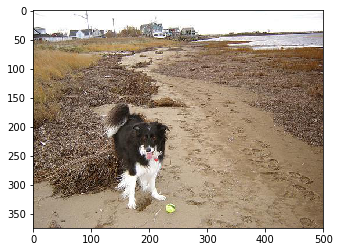

In [32]:
%matplotlib inline
# importing the requests library 
import requests 
import os, json, base64
from io import BytesIO
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import urllib.request
import io

##Get random dog
def get_random_dog():
    r = requests.get(url ="https://dog.ceo/api/breeds/image/random")
    URL= r.json()['message']
    return URL

##Get Random Dog Image
URL = get_random_dog()

##whippet Example 
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12223018/Whippet-On-White-03.jpg"

##italian greyhound Example
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12231757/Italian-Greyhound-On-White-03.jpg"

##chihuahua Example
# URL ="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12213613/Chihuahua-onWhite-13.jpg"

##whippet
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12223018/Whippet-On-White-03.jpg"

##italian greyhound
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12231757/Italian-Greyhound-On-White-03.jpg"

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

# ## If you downloaded the dataset, you can try this arbitrary image from the test dataset
# # test_img = os.path.join('breeds-10', 'val', 'n02085620-Chihuahua', 'n02085620_1271.jpg') 

plt.imshow(Image.open(test_img))

In [33]:
def imgToBase64(img):
    """Convert pillow image to base64-encoded image"""
    imgio = BytesIO()
    img.save(imgio, 'JPEG')
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

base64Img = imgToBase64(Image.open(test_img))

result = service.run(input_data=json.dumps({'data': base64Img}))
print(json.loads(result))

{'label': 'malamute', 'probability': '0.8011358'}


## Test the web service from within Visual Studio Code (Optional)

Now let's write a Python script in Visual Studio Code to call the web service for predicting dog breeds. 

Here are the steps we will go through in VS Code:
1. Import a Jupyter Notebook
2. Explore the AML workspace
3. Test the web service

### 0. Prerequisites

0.1. Visual Studio Code is a free, lightweight, cross-platform code editor. [Install Visual Studio Code](https://code.visualstudio.com/) if you don't have it installed.
![VS Code](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/VSCode.PNG)

0.2. Install the Microsoft Python extension in VS Code.
![Python extension](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/PythonExt.PNG)

0.3. Install the Azure Machine Learning extension in VS Code.
![AML extension](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/AMLExt.PNG)

### 1. Import a Jupyter Notebook

First, [Download this Jupyter Notebook](https://github.com/ronglums/PyCon-2019/blob/master/Test%20in%20Visual%20Studio%20Code.ipynb) onto your local machine. This notebooks contains the same code we used above to test the web service, but in a separate notebook file. Now we will import this notebook file into VS Code.

Launch VS Code, use menu `File->Open Folder` to open the folder where you save the Jupyter Notebook file. 
![Open Folder in VS Code](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/OpenFolder.png)

In the EXPLORER window in VS Code, click on the `Test in Visual Studio Code.ipynb` file, and you should see a notification messgae in the bottom right corner. Choose `Yes` to import the Notebook into Python code.
![Import Jupyter Notebook into Python code in VS Code](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/Import.PNG)

Import takes a few seconds. Once finished, you will have a Python file created like the following:
![Import finished](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/ImportDone.PNG)

### 2. Explore the AML workspace
Before we can test the web service in VS Code, we need to fill in the service uri that we will be testing. The [Azure Machine Learning extension for VS Code](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.vscode-ai) provides an easy way to build, train, and deploy machine learning models to the AML service. Now let's use it to find out what the service uri is for the service we just deployed.

Click on the `Azure` tab in the VS Code Activity bar. Use the AAD credentials provides to you to log in. Expand the `PyCon2019` workspace, and look for your service under `Deployments`. Then right click on your service and choose `View Service Properties`.
![Find service](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/FindService.PNG)

In the Properties page, find the scoringuri on line 78. Copy the value to clipboard.
![ScoringUri](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/ScoringURI.PNG)

### 3. Test the web service
Now switch back to the Python file that was imported, paste the scoringuri value at line 39.
![Paste ScoringUri in the Python code](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/PasteScoringURI.PNG)

Now we are ready to run the Python code to send a dog image to the web service to predict the dog breed. To better visualize the program results, we are going to run the code in the `Python Interactive` window, which brings the power of Jupyter Notebooks into VS Code.

Scroll to the top of the Python file, and click on the `Run Cell` link. This will launch a Jupyter server on the local machine, which will then be used to execute the code. Results are sent back to VS Code for presentation.
![Run Cell](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/RunCell.PNG)


**If you don't have Jupyter installed on your local machine**, you will be prompted this message. 
Please follow the steps here: [Installing Jupyter Notebook
](https://jupyter.readthedocs.io/en/latest/install.html).

Once the cell finished running, you will see a dog image along with the code in the `Python Interactive` window: 
![First cell result](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/1stCell.PNG)

Continue to run the second cell, which sends back the prediction result:
![Second cell result](https://github.com/ronglums/PyCon-2019/raw/master/screenshots/2ndcell.PNG)

### Delete web service
Once you no longer need the web service, you should delete it.

In [ ]:
service.delete()